In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from pathlib import Path
import pickle
from collections import OrderedDict
import pandas as pd
import numpy as np
import scipy
from scipy import stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 

import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from IPython.display import HTML

# Statlog (Heart) Data Set
https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/

Attribute Information:
------------------------
      -- 1. age       
      -- 2. sex       
      -- 3. chest pain type  (4 values)       
      -- 4. resting blood pressure  
      -- 5. serum cholestoral in mg/dl      
      -- 6. fasting blood sugar > 120 mg/dl       
      -- 7. resting electrocardiographic results  (values 0,1,2) 
      -- 8. maximum heart rate achieved  
      -- 9. exercise induced angina    
      -- 10. oldpeak = ST depression induced by exercise relative to rest   
      -- 11. the slope of the peak exercise ST segment     
      -- 12. number of major vessels (0-3) colored by flourosopy        
      -- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect     
Final column:
Absence (1) or presence (2) of heart disease

(I will change it to 1 for HD and 0 for none later on)

In [11]:
import logging

logging.basicConfig(filename='app.log', 
                    filemode='w',
                    format='%(asctime)s - %(name)s %(levelname)s %(message)s', 
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.DEBUG)

logging.info('App started')


In [10]:
import sys
print('Number of arguments:', len(sys.argv), 'arguments.')
print( 'Argument List:', str(sys.argv))


Number of arguments: 3 arguments.
Argument List: ['/opt/conda/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/daldebak/.local/share/jupyter/runtime/kernel-ff04274e-16a0-4b79-8c63-ea0aac26fc17.json']


In [2]:
colnames=['age','sex','chestpain','restbp','cholestoral',
          'bsugar','electrocardiographic','maxhr','angina',
          'oldpeak','slopepexercise','numvessels','thal',
          'heartdisease'
         ]

In [8]:
#https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/
df=pd.read_csv('test/testdata/heart.csv')
df=df.astype(float)
df.describe()

,age,sex,chestpain,restbp,cholestoral,bsugar,electrocardiographic,maxhr,angina,oldpeak,slopepexercise,numvessels,thal,heartdisease
count,270.000000,270.0,270.0,270.0,270.0,270.0,270.0,270.000000,270.0,270.0,270.0,270.0,270.0,270.000000
mean,54.433333,0.0,0.0,0.0,0.0,0.0,0.0,149.677778,0.0,0.0,0.0,0.0,0.0,1.444444
std,9.109067,0.0,0.0,0.0,0.0,0.0,0.0,23.165717,0.0,0.0,0.0,0.0,0.0,0.497827
min,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,71.000000,0.0,0.0,0.0,0.0,0.0,1.000000
25%,48.000000,0.0,0.0,0.0,0.0,0.0,0.0,133.000000,0.0,0.0,0.0,0.0,0.0,1.000000
50%,55.000000,0.0,0.0,0.0,0.0,0.0,0.0,153.500000,0.0,0.0,0.0,0.0,0.0,1.000000
75%,61.000000,0.0,0.0,0.0,0.0,0.0,0.0,166.000000,0.0,0.0,0.0,0.0,0.0,2.000000
max,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,202.000000,0.0,0.0,0.0,0.0,0.0,2.000000


In [3]:
#https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/
df=pd.DataFrame([line.split() for line in open('data/raw/heart.dat')],columns=colnames)
df=df.astype(float)

In [4]:
df.describe()

,age,sex,chestpain,restbp,cholestoral,bsugar,electrocardiographic,maxhr,angina,oldpeak,slopepexercise,numvessels,thal,heartdisease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,1.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,1.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,2.000000


Removing zero sd columns (eg for test data)

In [23]:
df=df.loc[:,df.std()!=0]

In [25]:
colnames=df.columns

Normalizing features

In [5]:
featuremeans=df[colnames[:-1]].mean()
featurestds=df[colnames[:-1]].std()
df[colnames[:-1]]=(df[colnames[:-1]]-featuremeans)/featurestds
df.describe()

,age,sex,chestpain,restbp,cholestoral,bsugar,electrocardiographic,maxhr,angina,oldpeak,slopepexercise,numvessels,thal,heartdisease
count,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,270.000000
mean,3.708967e-16,5.263280e-17,4.276415e-17,5.781384e-16,-2.006625e-16,6.291264e-17,9.292978e-17,-4.934325e-18,2.417819e-16,3.264878e-16,-9.457455e-17,1.151342e-17,-1.348715e-16,1.444444
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.497827
min,-2.792090e+00,-1.447639e+00,-2.288282e+00,-2.090766e+00,-2.392499e+00,-4.162558e-01,-1.024382e+00,-3.396302e+00,-6.999225e-01,-9.168625e-01,-9.524656e-01,-7.102161e-01,-8.740826e-01,1.000000
25%,-7.062560e-01,-1.447639e+00,-1.832185e-01,-6.351301e-01,-7.092654e-01,-4.162558e-01,-1.024382e+00,-7.199336e-01,-6.999225e-01,-9.168625e-01,-9.524656e-01,-7.102161e-01,-8.740826e-01,1.000000
50%,6.220908e-02,6.882217e-01,-1.832185e-01,-7.527007e-02,-9.014507e-02,-4.162558e-01,9.798441e-01,1.649948e-01,-6.999225e-01,-2.183006e-01,6.751655e-01,-7.102161e-01,-8.740826e-01,1.000000
75%,7.208935e-01,6.882217e-01,8.693133e-01,4.845899e-01,5.870178e-01,-4.162558e-01,9.798441e-01,7.045852e-01,1.423438e+00,4.802613e-01,6.751655e-01,3.492223e-01,1.187073e+00,2.000000
max,2.477385e+00,6.882217e-01,8.693133e-01,3.843750e+00,6.081711e+00,2.393471e+00,9.798441e-01,2.258606e+00,1.423438e+00,4.496992e+00,2.302797e+00,2.468099e+00,1.187073e+00,2.000000


In [6]:
df['heartdisease']-=1
df['heartdisease'].mean()

0.4444444444444444

44.4% of the dataset has heartdisease

In [7]:
df.describe()

,age,sex,chestpain,restbp,cholestoral,bsugar,electrocardiographic,maxhr,angina,oldpeak,slopepexercise,numvessels,thal,heartdisease
count,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02,270.000000
mean,3.708967e-16,5.263280e-17,4.276415e-17,5.781384e-16,-2.006625e-16,6.291264e-17,9.292978e-17,-4.934325e-18,2.417819e-16,3.264878e-16,-9.457455e-17,1.151342e-17,-1.348715e-16,0.444444
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.497827
min,-2.792090e+00,-1.447639e+00,-2.288282e+00,-2.090766e+00,-2.392499e+00,-4.162558e-01,-1.024382e+00,-3.396302e+00,-6.999225e-01,-9.168625e-01,-9.524656e-01,-7.102161e-01,-8.740826e-01,0.000000
25%,-7.062560e-01,-1.447639e+00,-1.832185e-01,-6.351301e-01,-7.092654e-01,-4.162558e-01,-1.024382e+00,-7.199336e-01,-6.999225e-01,-9.168625e-01,-9.524656e-01,-7.102161e-01,-8.740826e-01,0.000000
50%,6.220908e-02,6.882217e-01,-1.832185e-01,-7.527007e-02,-9.014507e-02,-4.162558e-01,9.798441e-01,1.649948e-01,-6.999225e-01,-2.183006e-01,6.751655e-01,-7.102161e-01,-8.740826e-01,0.000000
75%,7.208935e-01,6.882217e-01,8.693133e-01,4.845899e-01,5.870178e-01,-4.162558e-01,9.798441e-01,7.045852e-01,1.423438e+00,4.802613e-01,6.751655e-01,3.492223e-01,1.187073e+00,1.000000
max,2.477385e+00,6.882217e-01,8.693133e-01,3.843750e+00,6.081711e+00,2.393471e+00,9.798441e-01,2.258606e+00,1.423438e+00,4.496992e+00,2.302797e+00,2.468099e+00,1.187073e+00,1.000000


### Plotting correlations between the attributes, and to our target variable (heart disease)

Biggest negative correlatioln is maxhr versus age. Makes sense...older people have lower heart rates.

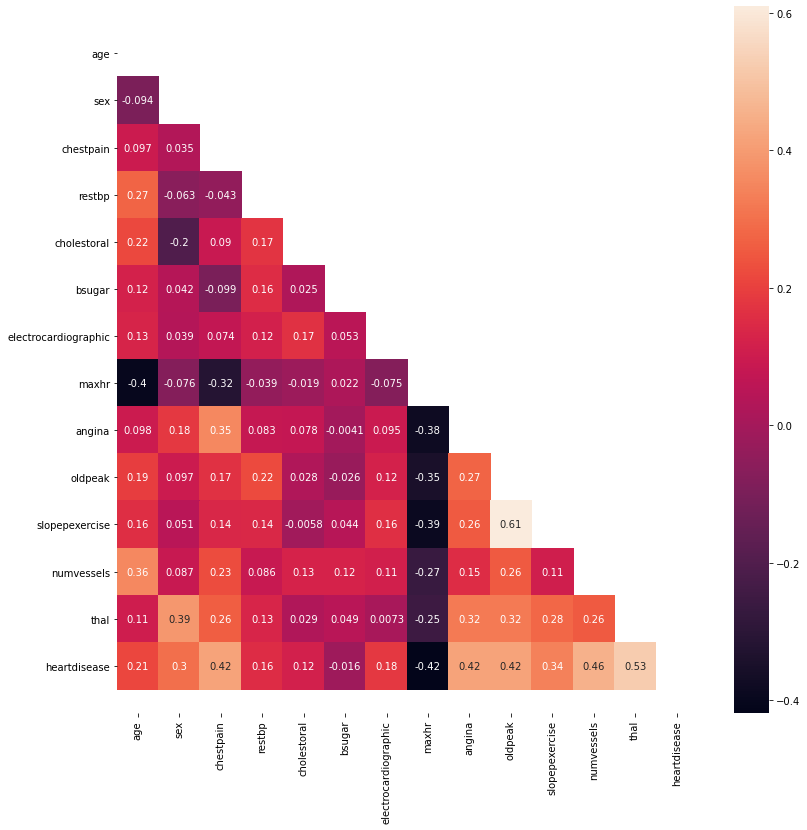

In [8]:
plt.figure(figsize=(13, 13))
corr = df.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr, mask=mask, annot=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()

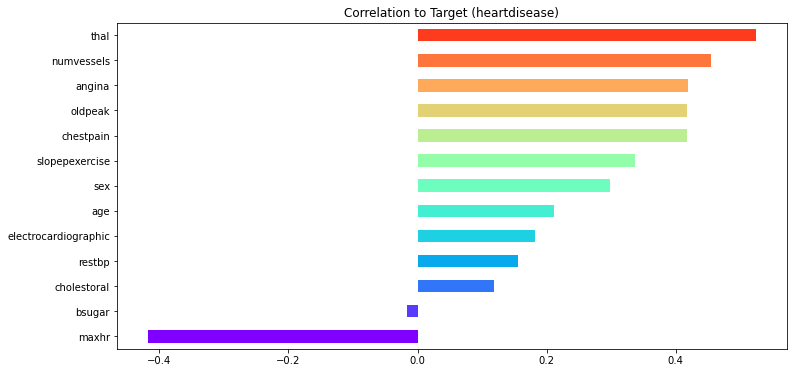


 thal                    0.525020
numvessels              0.455336
angina                  0.419303
oldpeak                 0.417967
chestpain               0.417436
slopepexercise          0.337616
sex                     0.297721
age                     0.212322
electrocardiographic    0.182091
restbp                  0.155383
cholestoral             0.118021
bsugar                 -0.016319
maxhr                  -0.418514
dtype: float64


In [9]:
n_fts = len(df.columns)
colors = cm.rainbow(np.linspace(0, 1, n_fts))

df.drop('heartdisease',axis=1).corrwith(df.heartdisease).sort_values(ascending=True).plot(kind='barh', 
                                                                                     color=colors, figsize=(12, 6))
plt.title('Correlation to Target (heartdisease)')
plt.show()

print('\n',df.drop('heartdisease',axis=1).corrwith(df.heartdisease).sort_values(ascending=False))

# Defining the model 
We will use ALL of the features given, even though another idea is to filter out some of the lower correlations above.


In [10]:
full_model=colnames[-1]+' ~ '+' + '.join(colnames[:-1])
full_model

'heartdisease ~ age + sex + chestpain + restbp + cholestoral + bsugar + electrocardiographic + maxhr + angina + oldpeak + slopepexercise + numvessels + thal'

In [11]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=df,
                            family=pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [12]:
logistic_model.basic_RVs

[Intercept ~ Flat,
 age ~ Normal,
 sex ~ Normal,
 chestpain ~ Normal,
 restbp ~ Normal,
 cholestoral ~ Normal,
 bsugar ~ Normal,
 electrocardiographic ~ Normal,
 maxhr ~ Normal,
 angina ~ Normal,
 oldpeak ~ Normal,
 slopepexercise ~ Normal,
 numvessels ~ Normal,
 thal ~ Normal,
 y ~ Binomial]

## Markov Chain Monte Carlo (MCMC)
Using the NUTS sampler built into PyMC3

In [13]:
import time
start = time.time()
with logistic_model:
    trace_NUTS  = pm.sample(tune=20000,
                         draws=20000,
                         chains=4,
                         init = 'adapt_diag',
                         cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [thal, numvessels, slopepexercise, oldpeak, angina, maxhr, electrocardiographic, bsugar, cholestoral, restbp, chestpain, sex, age, Intercept]


Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 586 seconds.


In [14]:
mcmcruntime = time.time()-start
mcmcruntime

613.5156197547913

### Inspect Trace


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


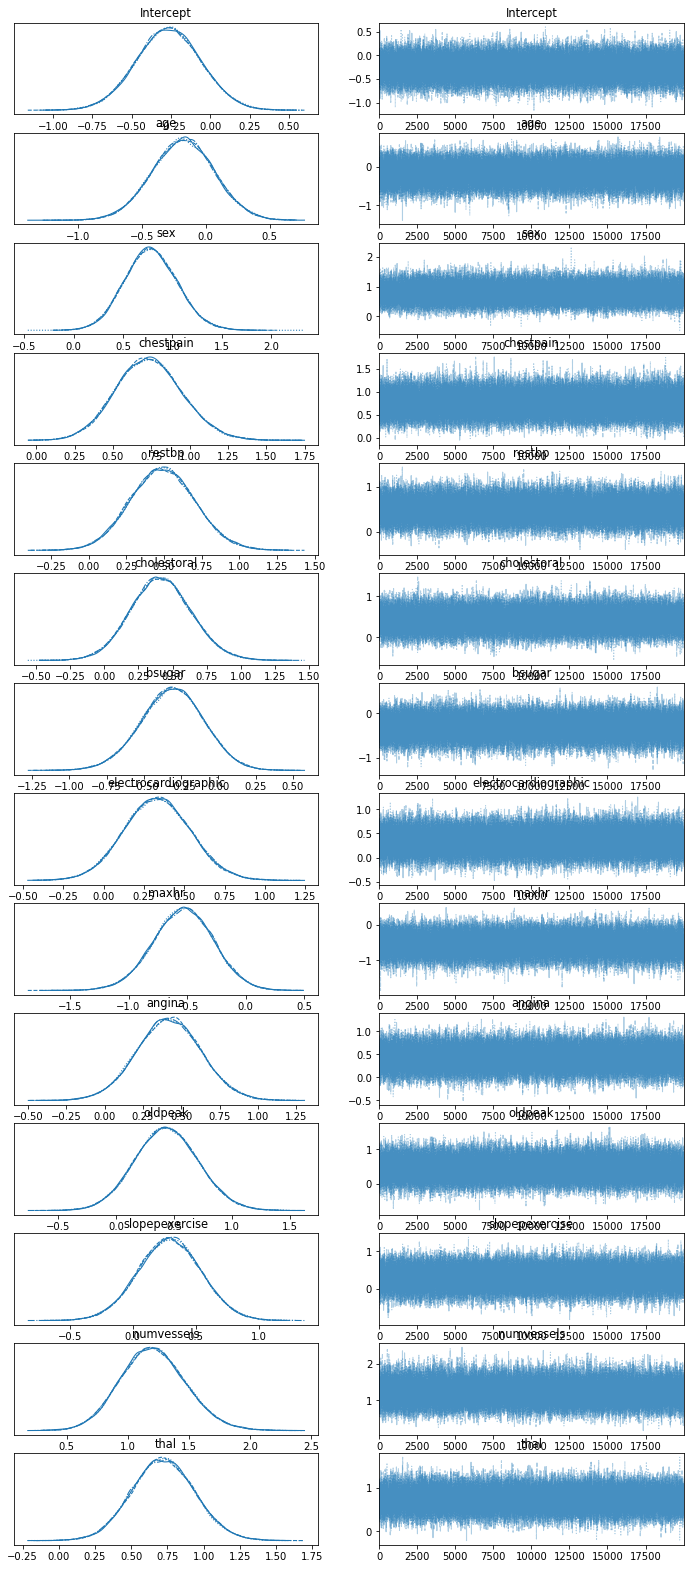

In [15]:
pm.plot_trace(trace_NUTS );


In [16]:
tracedf=pm.trace_to_dataframe(trace_NUTS )
tracedf

,Intercept,age,sex,chestpain,restbp,cholestoral,bsugar,electrocardiographic,maxhr,angina,oldpeak,slopepexercise,numvessels,thal
0,-0.421106,-0.027790,0.903181,0.561281,0.488086,0.557555,-0.213286,0.296064,-0.306003,0.570878,0.194037,0.061591,0.660641,0.334564
1,-0.031332,-0.109612,0.969167,0.921078,0.417668,0.099077,-0.432192,0.268367,-0.409988,0.381276,0.747806,0.401922,1.488647,0.756119
2,-0.565471,-0.379617,1.093592,0.747175,0.595862,0.543290,-0.260997,0.060519,-1.080096,0.623861,0.270773,0.087455,1.162206,0.700283
3,-0.477399,-0.509102,1.121516,0.616986,0.472997,0.913308,0.066976,0.128411,-1.054699,0.608330,0.150674,0.500849,1.159873,0.790968
4,-0.457728,-0.423354,1.029389,0.551907,0.410544,0.793138,-0.361315,0.008273,-0.723334,0.347767,0.042980,0.660575,1.545003,0.782330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,-0.157082,-0.048186,1.041464,0.767420,0.660464,0.338506,-0.742752,0.207500,-0.459227,0.422918,0.528090,-0.007379,1.295829,0.304035
79996,-0.181178,-0.138470,0.457959,0.029663,0.448610,0.173292,-0.310975,0.178930,-0.617902,0.621347,0.878612,0.027495,0.977646,0.527421
79997,-0.004071,-0.435726,0.709298,0.886099,0.456997,0.305740,0.040305,0.315298,-0.855239,0.383201,0.428982,-0.098565,1.037056,0.480918
79998,-0.507532,0.070118,0.526911,0.844332,0.291574,0.124573,-0.671182,0.395320,-0.264811,0.489434,0.427082,0.553154,1.337078,0.914904


As seen above, we have all the samples as rows.

In [17]:
mcmcresults=pm.summary(trace_NUTS )
mcmcresults

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.265,0.206,-0.652,0.124,0.001,0.001,112293.0,64997.0,1.0
age,-0.178,0.244,-0.638,0.279,0.001,0.001,97536.0,63621.0,1.0
sex,0.785,0.266,0.286,1.285,0.001,0.001,93353.0,63910.0,1.0
chestpain,0.737,0.217,0.339,1.156,0.001,0.000,108252.0,68092.0,1.0
restbp,0.493,0.215,0.087,0.896,0.001,0.001,93465.0,64616.0,1.0
cholestoral,0.416,0.223,-0.001,0.838,0.001,0.001,103632.0,70234.0,1.0
bsugar,-0.310,0.212,-0.716,0.084,0.001,0.001,112145.0,68536.0,1.0
electrocardiographic,0.332,0.207,-0.051,0.727,0.001,0.000,115761.0,64294.0,1.0
maxhr,-0.534,0.258,-1.017,-0.044,0.001,0.001,100551.0,65125.0,1.0
angina,0.420,0.212,0.026,0.824,0.001,0.000,112787.0,63440.0,1.0


### Posterior Plot


Got error No model on context stack. trying to find log_likelihood in translation.


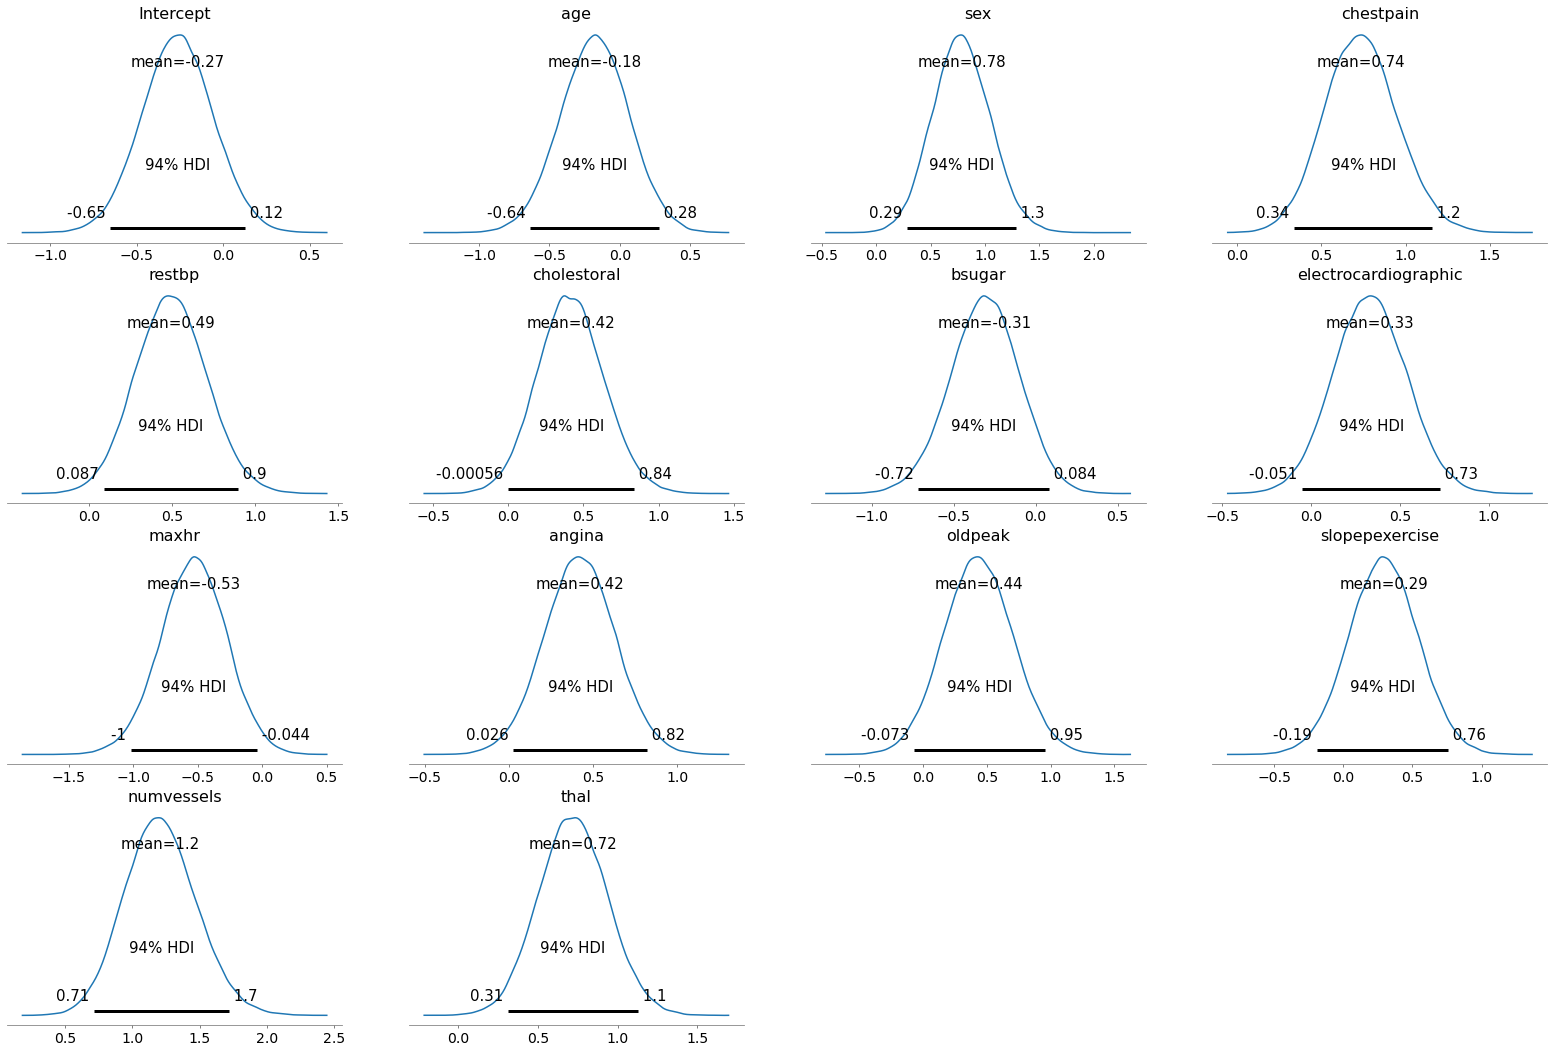

In [18]:
pm.plot_posterior(trace_NUTS);


## Comparing the results of NUTS vs Sklearn/SMF

### Logistic Regression based on NUTS sampler versus  sklearn.linear_model.LogisticRegression


In [19]:
start = time.time()
from sklearn.linear_model import LogisticRegression
X=df[colnames[:-1]].values
y=df[colnames[-1]].values
clf = LogisticRegression().fit(X, y)
sklearnruntime = time.time()-start
clf.coef_

array([[-0.12580084,  0.66877726,  0.63684872,  0.40730943,  0.33883204,
        -0.25416623,  0.29079339, -0.45851916,  0.37957175,  0.39221287,
         0.25308226,  1.01952846,  0.64987814]])

In [20]:
clf.intercept_

array([-0.2538742])

In [21]:
accuracy=clf.score(X, y)
print('SKlearn Logistic Regression Accuracy ={:.3f} Runtime(s) = {:.2f}'.format(accuracy,sklearnruntime))

SKlearn Logistic Regression Accuracy =0.852 Runtime(s) = 0.05


Now compare to results from MCMC

In [22]:
clf.intercept_[0]=mcmcresults['mean'].values[0]
clf.coef_[0]=mcmcresults['mean'].values[1:]
accuracy=clf.score(X, y)
print('MCMC (NUTS) Accuracy ={:.3f} Runtime(s) = {:.2f}'.format(accuracy,mcmcruntime))

MCMC (NUTS) Accuracy =0.856 Runtime(s) = 613.52


The result from MCMC is actually better than sklearn's logistic regression


### Logistic Regression based on NUTS sampler versus  smf.logit

I tried running this but it takes WAY too long <br>
I guess this is why we need MCMC or VI methods!<br>

model = smf.logit(formula=full_model, data=df[colnames[-1:]+colnames[:-1]].values)<br>
result = model.fit()<br>
print(result.summary())<br>

## Automatic Differentation Variational Inference (ADVI)

In [23]:
start = time.time()
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=100000, callbacks=[callback])
trace_advi = approx.sample(2000)
adviruntime = time.time()-start

Finished [100%]: Average Loss = 201.39


In [24]:
adviresults=pm.summary(trace_advi)
adviresults


Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.279,0.219,-0.690,0.131,0.005,0.004,2055.0,2006.0,NaN
age,-0.193,0.213,-0.554,0.253,0.005,0.004,1764.0,1922.0,NaN
sex,0.800,0.232,0.363,1.210,0.005,0.004,2071.0,2004.0,NaN
chestpain,0.747,0.220,0.314,1.133,0.005,0.004,1875.0,1846.0,NaN
restbp,0.493,0.208,0.131,0.917,0.005,0.003,1892.0,1719.0,NaN
cholestoral,0.409,0.219,0.034,0.837,0.005,0.004,1923.0,1830.0,NaN
bsugar,-0.307,0.214,-0.693,0.085,0.005,0.004,1962.0,1794.0,NaN
electrocardiographic,0.338,0.221,-0.093,0.741,0.005,0.004,2012.0,2055.0,NaN
maxhr,-0.541,0.231,-0.969,-0.100,0.006,0.004,1711.0,1611.0,NaN
angina,0.430,0.223,-0.002,0.840,0.005,0.003,2057.0,2018.0,NaN


In [25]:
clf.intercept_[0]=adviresults['mean'].values[0]
clf.coef_[0]=adviresults['mean'].values[1:]
accuracy=clf.score(X, y)
print('ADVI Accuracy ={:.3f} Runtime(s) = {:.2f}'.format(accuracy,adviruntime))

ADVI Accuracy =0.859 Runtime(s) = 86.56


Sklearn's logistic regression is the fastest for this dataset.

ADVI is the 2nd fastest.

Finally MCMC is the slowest.

They all have the same accuracy using the mean parameters but MCMC captures the covariance structure best as we will show in the next section


## Visualizing covariance structure of the model's latent variables
### Using MCMC

Got error No model on context stack. trying to find log_likelihood in translation.


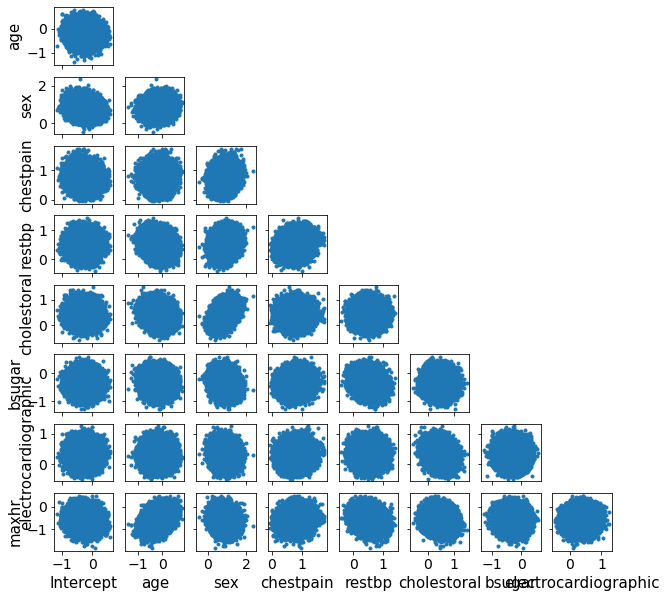

In [26]:
az.plot_pair(trace_NUTS, figsize=(10, 10));


### MCMC captures the covariance structure of the model's latent variables, but it is slower than ADVI

How do we reconcile (1) negative correlation between maxhr and age, (2) the negative correlation between maxhr and heart disease, and (3) the positive correlation between the latent variable related to age with the latent variable related to maxhr? 

According to Journal of the American Medical Association, a higher heart rate INCREASES the chance of heart disease. However, simple correlation results in figure 2 shows that higher heart rate decreases the chance of heart disease. This is likely due to a higher heart rate also capturing younger (smaller age value) individuals, who tend to be healthy. (Albeit, at a given age, a higher heart rate is bad.) Therefore, there is a strong positive covariance between latent variable related to maxhr and the latent variable age. When the model increases exposure to maxhr to capture heart disease, it would naturally falsely predict younger individuals as having heart disease, and this would be solved with a corresponding increased exposure to age. 

Hence, MCMC captures the covariance structure of the model's latent variables, but it is slower than ADVI. For the same training accuracy of 0.856, it has a runtime of 414 seconds versus 42 seconds for ADVI.


### Using ADVI

Got error No model on context stack. trying to find log_likelihood in translation.


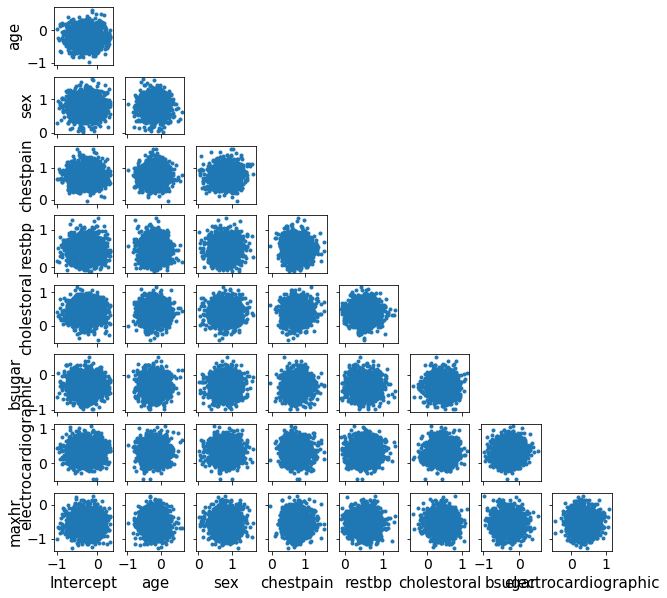

In [27]:
az.plot_pair(trace_advi, figsize=(10, 10));


ADVI does not capture interactions between variables because of the mean field approximation.
The covariance matrix is a trivial diagonal matrix and so it underestimates the overall variance. 

Notably, the covariance between age and heart rate is not captured.

### Calculate FN for ADVI


In [28]:
samples=[]
for v in trace_advi._straces[0].samples.values():
    samples.append(v)
samples=np.array(samples)
samples

array([[ 0.03889816,  0.02577604, -0.2685532 , ..., -0.55768234,
        -0.22109031, -0.5987832 ],
       [-0.35399068, -0.22828935, -0.06720459, ..., -0.2036493 ,
         0.06622949, -0.22318541],
       [ 0.4981474 ,  0.84970525,  0.46450676, ...,  0.77197155,
         0.8625384 ,  0.7173275 ],
       ...,
       [ 0.58319582,  0.35040771, -0.12415162, ...,  0.26362815,
         0.07463116,  0.17971454],
       [ 1.36173813,  1.1432023 ,  1.08847406, ...,  1.12761685,
         1.38594606,  1.27288935],
       [ 0.86498187,  0.20389724,  0.48405113, ...,  0.93945668,
         0.71846997,  0.82998556]])

In [29]:
covadvi=np.cov(samples)
oadvi=np.linalg.inv(covadvi)

As expected the sample covariance from ADVI is largely a diagonal matrix

In [32]:
covadvi

array([[ 4.79846019e-02, -1.01334886e-03,  1.22787682e-03,
        -3.86255923e-04,  3.79620562e-04, -1.97450587e-03,
        -1.72825501e-04, -4.77058181e-04,  9.60641103e-04,
        -1.15687932e-03, -7.48439429e-04, -8.06797937e-04,
         1.30355673e-03, -4.87957406e-04],
       [-1.01334886e-03,  4.53868208e-02, -2.05863182e-04,
         5.19512823e-04, -1.84769028e-03, -1.21643383e-03,
         1.07904671e-03,  1.46619868e-03, -1.03757370e-03,
         9.08596326e-04, -1.13147832e-03, -5.13948416e-04,
         1.75287503e-03,  3.98058617e-04],
       [ 1.22787682e-03, -2.05863182e-04,  5.37115801e-02,
         1.03249163e-05,  5.99968899e-04,  2.07722571e-03,
        -1.13368484e-03,  1.09099374e-03,  1.37596780e-03,
         9.54572473e-04,  4.09945428e-03, -2.24927140e-04,
         5.77989951e-04,  1.63791985e-04],
       [-3.86255923e-04,  5.19512823e-04,  1.03249163e-05,
         4.82944581e-02, -2.41312727e-03,  8.48786504e-04,
         6.95441091e-04, -2.91509730e-03, -7.

In [34]:
covactual=tracedf.cov().values
oactual=np.linalg.inv(covactual)
om=np.linalg.inv(covadvi)
fn=np.linalg.norm(oactual-om)
print('For ADVI, FN ={} log(FN)={}'.format(fn,np.log(fn)))

For ADVI, FN =45.24289718438833 log(FN)=3.8120456895243118


# Now doing VI with non-trival covariance as in capstone pdf.


In [35]:
mu_star=mcmcresults['mean'].values
covactual=tracedf.cov().values
oactual=np.linalg.inv(covactual)
d=len(mu_star)
oactual.shape

(14, 14)

In [45]:

def omega(u0,U,Λ):
    return np.identity(d)*u0**2 + np.matmul(np.matmul(U,Λ),U.T)

def omega2(oactual,U,Λ):
    return np.diag(oactual)*np.identity(d) + np.matmul(np.matmul(U,Λ),U.T)

## First using phi by querying versus log pdf based on $\mu^*$ and $\Omega^*$
(This runs faster as we do not have to evaluate versus samples of "x")

In [46]:
def phi(theta):
    return 8.5-scipy.stats.multivariate_normal.logpdf(theta, mean=mu_star, cov=covactual, allow_singular=False)


A good phi value:

In [47]:
phi(mu_star)

0.029869979393616575

A bad phi value:

In [48]:
phi(np.zeros(d))

39.57553588105903

## Exploring methodologies
Although the capstone pdf does not state this, we determined that the best convergence is achieved if we demeaned phi (so it is possibly negative in the update eq), and also demeaned thetas.

In [49]:
import scipy
import scipy.stats as st
from collections import defaultdict


FNByMethod=defaultdict(list)

for demeanphi in [True, False]:
    for demeantheta in [True, False]:
        p=14
        Λ = np.identity(p)
        U=np.eye(d,p)
        u0=1
        u0t,Ut,Λt=u0,U,Λ

        for t in range(2000):

            u0t=1.0
            om=omega(u0t,Ut,Λt) #as per pdf 165
            thiscov=np.linalg.inv(om)

            #Sample as per equation 6
            num_samples=10+t
            #num_samples=1000
            samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
            phis=phi(samples)
            if demeanphi:
                phis-=phis.mean()
            expphi=np.abs(phis).mean()        

            ht=0.01/(1+expphi)
            ht*=500/(t+500)  

            t2sum=0
            denom=0
            for thisphi,thetajt in zip(phis,samples):
                if demeantheta:
                    thetajt=(thetajt-mu_star).reshape((d,1))
                else:
                    thetajt=(thetajt).reshape((d,1))
                #original formula
                t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
                #simplified formula
                #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
                denom+=1
            if denom:
                t2sum/=denom
                #original formula
                Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
                #simplified formula
                #Ut=Ut-ht*t2sum 

            #update as per equation 8
            q, r = scipy.linalg.qr(Ut,mode='economic')
            Ut=q

            if t%10==0: 
                #updating eigenvalues as per pdf 191
                om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
                for i in range(p):
                    ui=Ut[:,i]
                    Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
                om=omega(u0t,Ut,Λt) #as per pdf 165

                #suggested by mentor: Frobenius Norm
                fn=np.linalg.norm(oactual-om)
                FNByMethod[(demeanphi,demeantheta)].append(fn)
                print('demeanphi={} demeantheta={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(demeanphi,demeantheta,t,expphi,fn))
                
                
        

demeanphi=True demeantheta=True epoach 0 avg phi 28.3000 Frobenius Norm 42.1297
demeanphi=True demeantheta=True epoach 10 avg phi 1.2683 Frobenius Norm 40.8308
demeanphi=True demeantheta=True epoach 20 avg phi 1.9988 Frobenius Norm 36.1596
demeanphi=True demeantheta=True epoach 30 avg phi 2.0884 Frobenius Norm 31.9604
demeanphi=True demeantheta=True epoach 40 avg phi 2.8082 Frobenius Norm 30.6612
demeanphi=True demeantheta=True epoach 50 avg phi 2.1098 Frobenius Norm 26.2857
demeanphi=True demeantheta=True epoach 60 avg phi 1.9912 Frobenius Norm 24.2134
demeanphi=True demeantheta=True epoach 70 avg phi 2.1622 Frobenius Norm 22.5309
demeanphi=True demeantheta=True epoach 80 avg phi 2.1502 Frobenius Norm 22.5798
demeanphi=True demeantheta=True epoach 90 avg phi 2.2087 Frobenius Norm 19.7245
demeanphi=True demeantheta=True epoach 100 avg phi 2.4585 Frobenius Norm 19.5237
demeanphi=True demeantheta=True epoach 110 avg phi 2.1614 Frobenius Norm 16.8937
demeanphi=True demeantheta=True epoach

demeanphi=True demeantheta=True epoach 1030 avg phi 2.0776 Frobenius Norm 4.2002
demeanphi=True demeantheta=True epoach 1040 avg phi 2.0917 Frobenius Norm 4.1054
demeanphi=True demeantheta=True epoach 1050 avg phi 2.0431 Frobenius Norm 4.1618
demeanphi=True demeantheta=True epoach 1060 avg phi 2.2045 Frobenius Norm 3.7647
demeanphi=True demeantheta=True epoach 1070 avg phi 2.0482 Frobenius Norm 3.9094
demeanphi=True demeantheta=True epoach 1080 avg phi 2.0913 Frobenius Norm 4.1836
demeanphi=True demeantheta=True epoach 1090 avg phi 2.1019 Frobenius Norm 4.1374
demeanphi=True demeantheta=True epoach 1100 avg phi 2.0639 Frobenius Norm 4.1456
demeanphi=True demeantheta=True epoach 1110 avg phi 2.0778 Frobenius Norm 3.7885
demeanphi=True demeantheta=True epoach 1120 avg phi 2.0885 Frobenius Norm 3.3988
demeanphi=True demeantheta=True epoach 1130 avg phi 2.0818 Frobenius Norm 3.5097
demeanphi=True demeantheta=True epoach 1140 avg phi 2.1517 Frobenius Norm 3.6440
demeanphi=True demeantheta=T

demeanphi=True demeantheta=False epoach 50 avg phi 2.3093 Frobenius Norm 39.2216
demeanphi=True demeantheta=False epoach 60 avg phi 2.5577 Frobenius Norm 38.2007
demeanphi=True demeantheta=False epoach 70 avg phi 2.5445 Frobenius Norm 40.6045
demeanphi=True demeantheta=False epoach 80 avg phi 2.0984 Frobenius Norm 38.4901
demeanphi=True demeantheta=False epoach 90 avg phi 2.2419 Frobenius Norm 35.3118
demeanphi=True demeantheta=False epoach 100 avg phi 2.0646 Frobenius Norm 33.3853
demeanphi=True demeantheta=False epoach 110 avg phi 2.3651 Frobenius Norm 35.5314
demeanphi=True demeantheta=False epoach 120 avg phi 2.3658 Frobenius Norm 32.7283
demeanphi=True demeantheta=False epoach 130 avg phi 2.6433 Frobenius Norm 31.5461
demeanphi=True demeantheta=False epoach 140 avg phi 2.1382 Frobenius Norm 29.2757
demeanphi=True demeantheta=False epoach 150 avg phi 2.2404 Frobenius Norm 28.3636
demeanphi=True demeantheta=False epoach 160 avg phi 2.0600 Frobenius Norm 28.1916
demeanphi=True demean

demeanphi=True demeantheta=False epoach 1060 avg phi 1.9821 Frobenius Norm 8.7626
demeanphi=True demeantheta=False epoach 1070 avg phi 2.0307 Frobenius Norm 9.5743
demeanphi=True demeantheta=False epoach 1080 avg phi 2.0644 Frobenius Norm 8.6227
demeanphi=True demeantheta=False epoach 1090 avg phi 1.9973 Frobenius Norm 7.7203
demeanphi=True demeantheta=False epoach 1100 avg phi 2.1251 Frobenius Norm 9.5297
demeanphi=True demeantheta=False epoach 1110 avg phi 2.0985 Frobenius Norm 9.1833
demeanphi=True demeantheta=False epoach 1120 avg phi 2.1404 Frobenius Norm 8.8366
demeanphi=True demeantheta=False epoach 1130 avg phi 2.0770 Frobenius Norm 10.7357
demeanphi=True demeantheta=False epoach 1140 avg phi 1.9986 Frobenius Norm 9.9513
demeanphi=True demeantheta=False epoach 1150 avg phi 2.0982 Frobenius Norm 10.5570
demeanphi=True demeantheta=False epoach 1160 avg phi 2.0432 Frobenius Norm 12.1229
demeanphi=True demeantheta=False epoach 1170 avg phi 2.0770 Frobenius Norm 9.1112
demeanphi=Tru

demeanphi=False demeantheta=True epoach 60 avg phi 6.8530 Frobenius Norm 34.1166
demeanphi=False demeantheta=True epoach 70 avg phi 6.9932 Frobenius Norm 33.2366
demeanphi=False demeantheta=True epoach 80 avg phi 6.6120 Frobenius Norm 31.5653
demeanphi=False demeantheta=True epoach 90 avg phi 7.0135 Frobenius Norm 31.0441
demeanphi=False demeantheta=True epoach 100 avg phi 6.7782 Frobenius Norm 31.7841
demeanphi=False demeantheta=True epoach 110 avg phi 6.8862 Frobenius Norm 29.7863
demeanphi=False demeantheta=True epoach 120 avg phi 6.9445 Frobenius Norm 29.1715
demeanphi=False demeantheta=True epoach 130 avg phi 7.0917 Frobenius Norm 27.8640
demeanphi=False demeantheta=True epoach 140 avg phi 7.2509 Frobenius Norm 27.7768
demeanphi=False demeantheta=True epoach 150 avg phi 7.0724 Frobenius Norm 27.5908
demeanphi=False demeantheta=True epoach 160 avg phi 7.1908 Frobenius Norm 27.2803
demeanphi=False demeantheta=True epoach 170 avg phi 7.3214 Frobenius Norm 26.2156
demeanphi=False deme

demeanphi=False demeantheta=True epoach 1070 avg phi 7.0606 Frobenius Norm 7.3808
demeanphi=False demeantheta=True epoach 1080 avg phi 6.8705 Frobenius Norm 7.0287
demeanphi=False demeantheta=True epoach 1090 avg phi 7.0567 Frobenius Norm 6.6017
demeanphi=False demeantheta=True epoach 1100 avg phi 6.9953 Frobenius Norm 6.4088
demeanphi=False demeantheta=True epoach 1110 avg phi 7.0384 Frobenius Norm 6.5837
demeanphi=False demeantheta=True epoach 1120 avg phi 7.0166 Frobenius Norm 6.6499
demeanphi=False demeantheta=True epoach 1130 avg phi 6.9120 Frobenius Norm 6.5683
demeanphi=False demeantheta=True epoach 1140 avg phi 7.0037 Frobenius Norm 7.1753
demeanphi=False demeantheta=True epoach 1150 avg phi 7.0505 Frobenius Norm 7.0268
demeanphi=False demeantheta=True epoach 1160 avg phi 7.0020 Frobenius Norm 6.4608
demeanphi=False demeantheta=True epoach 1170 avg phi 7.1110 Frobenius Norm 6.4166
demeanphi=False demeantheta=True epoach 1180 avg phi 6.9906 Frobenius Norm 6.2204
demeanphi=False 

demeanphi=False demeantheta=False epoach 70 avg phi 6.5873 Frobenius Norm 38.6253
demeanphi=False demeantheta=False epoach 80 avg phi 6.4775 Frobenius Norm 37.5743
demeanphi=False demeantheta=False epoach 90 avg phi 7.1064 Frobenius Norm 34.4580
demeanphi=False demeantheta=False epoach 100 avg phi 7.2111 Frobenius Norm 32.6115
demeanphi=False demeantheta=False epoach 110 avg phi 7.1371 Frobenius Norm 32.7792
demeanphi=False demeantheta=False epoach 120 avg phi 6.7129 Frobenius Norm 32.3288
demeanphi=False demeantheta=False epoach 130 avg phi 7.0840 Frobenius Norm 32.4722
demeanphi=False demeantheta=False epoach 140 avg phi 7.3464 Frobenius Norm 30.4816
demeanphi=False demeantheta=False epoach 150 avg phi 7.2695 Frobenius Norm 28.6369
demeanphi=False demeantheta=False epoach 160 avg phi 7.1127 Frobenius Norm 27.7592
demeanphi=False demeantheta=False epoach 170 avg phi 6.9567 Frobenius Norm 27.5488
demeanphi=False demeantheta=False epoach 180 avg phi 7.0990 Frobenius Norm 26.7482
demeanp

demeanphi=False demeantheta=False epoach 1060 avg phi 7.0406 Frobenius Norm 17.3596
demeanphi=False demeantheta=False epoach 1070 avg phi 7.0919 Frobenius Norm 16.6224
demeanphi=False demeantheta=False epoach 1080 avg phi 7.0912 Frobenius Norm 16.9820
demeanphi=False demeantheta=False epoach 1090 avg phi 7.1628 Frobenius Norm 16.5213
demeanphi=False demeantheta=False epoach 1100 avg phi 7.1916 Frobenius Norm 16.9247
demeanphi=False demeantheta=False epoach 1110 avg phi 6.9915 Frobenius Norm 16.5554
demeanphi=False demeantheta=False epoach 1120 avg phi 7.1748 Frobenius Norm 16.3936
demeanphi=False demeantheta=False epoach 1130 avg phi 6.9643 Frobenius Norm 16.6056
demeanphi=False demeantheta=False epoach 1140 avg phi 7.0799 Frobenius Norm 16.4782
demeanphi=False demeantheta=False epoach 1150 avg phi 7.0531 Frobenius Norm 16.5733
demeanphi=False demeantheta=False epoach 1160 avg phi 7.0153 Frobenius Norm 16.4791
demeanphi=False demeantheta=False epoach 1170 avg phi 7.0809 Frobenius Norm 

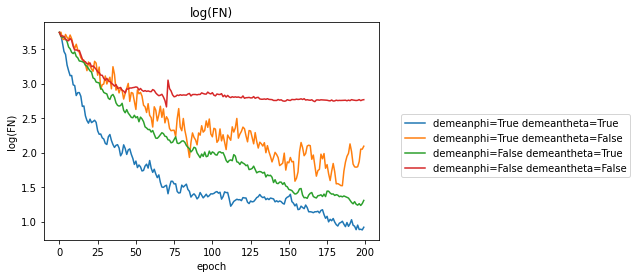

In [50]:
fig = plt.figure()
ax = plt.subplot(111)
for demeanphi in [True, False]:
    for demeantheta in [True, False]:
        ax.plot(range(len(FNByMethod[(demeanphi,demeantheta)])),np.log(FNByMethod[(demeanphi,demeantheta)]),label='demeanphi={} demeantheta={}'.format(demeanphi,demeantheta))
    
plt.ylabel('log(FN)')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.title('log(FN)')

plt.show()

In [ ]:
import scipy
import scipy.stats as st
from collections import defaultdict


FNByMethod=defaultdict(list)

for annealing in [True, False]:
    for eigenupdate in [True, False]:
        p=14
        Λ = np.identity(p)
        U=np.eye(d,p)
        u0=1
        u0t,Ut,Λt=u0,U,Λ

        for t in range(4000):

            u0t=1.0
            om=omega(u0t,Ut,Λt) #as per pdf 165
            thiscov=np.linalg.inv(om)

            #Sample as per equation 6
            num_samples=10+t
            #num_samples=1000
            samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
            phis=phi(samples)
            phis-=phis.mean()
            expphi=np.abs(phis).mean()        

            if annealing:
                ht=0.01/(1+expphi)
                ht*=500/(t+500)  
            else:
                ht=0.004/(1+expphi)
                

            t2sum=0
            denom=0
            for thisphi,thetajt in zip(phis,samples):
                thetajt=(thetajt-mu_star).reshape((d,1))
                #original formula
                t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
                #simplified formula
                #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
                denom+=1
            if denom:
                t2sum/=denom
                #original formula
                Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
                #simplified formula
                #Ut=Ut-ht*t2sum 

            #update as per equation 8
            q, r = scipy.linalg.qr(Ut,mode='economic')
            Ut=q
            
            if eigenupdate or t%10==0: 
                #updating eigenvalues as per pdf 191
                om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
                for i in range(p):
                    ui=Ut[:,i]
                    Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
                om=omega(u0t,Ut,Λt) #as per pdf 165
            if t%10==0: 
                #suggested by mentor: Frobenius Norm
                fn=np.linalg.norm(oactual-om)
                FNByMethod[(annealing,eigenupdate)].append(fn)
                print('annealing={} eigenupdate={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(annealing,eigenupdate,t,expphi,fn))
                
                
        

annealing=True eigenupdate=True epoach 0 avg phi 37.9118 Frobenius Norm 42.0575
annealing=True eigenupdate=True epoach 10 avg phi 2.0728 Frobenius Norm 37.5608
annealing=True eigenupdate=True epoach 20 avg phi 1.9106 Frobenius Norm 34.0967
annealing=True eigenupdate=True epoach 30 avg phi 2.2007 Frobenius Norm 31.1869
annealing=True eigenupdate=True epoach 40 avg phi 1.9598 Frobenius Norm 28.5950
annealing=True eigenupdate=True epoach 50 avg phi 2.4727 Frobenius Norm 27.4464
annealing=True eigenupdate=True epoach 60 avg phi 2.3122 Frobenius Norm 23.8417
annealing=True eigenupdate=True epoach 70 avg phi 2.0047 Frobenius Norm 23.5477
annealing=True eigenupdate=True epoach 80 avg phi 1.9099 Frobenius Norm 21.3291
annealing=True eigenupdate=True epoach 90 avg phi 2.0855 Frobenius Norm 19.2120
annealing=True eigenupdate=True epoach 100 avg phi 1.9159 Frobenius Norm 17.9191
annealing=True eigenupdate=True epoach 110 avg phi 2.1751 Frobenius Norm 17.1000
annealing=True eigenupdate=True epoach

annealing=True eigenupdate=True epoach 1030 avg phi 2.0644 Frobenius Norm 3.5410
annealing=True eigenupdate=True epoach 1040 avg phi 2.1793 Frobenius Norm 3.1877
annealing=True eigenupdate=True epoach 1050 avg phi 2.1479 Frobenius Norm 3.0408
annealing=True eigenupdate=True epoach 1060 avg phi 2.0833 Frobenius Norm 3.2312
annealing=True eigenupdate=True epoach 1070 avg phi 2.1171 Frobenius Norm 3.0916
annealing=True eigenupdate=True epoach 1080 avg phi 2.0625 Frobenius Norm 2.9816
annealing=True eigenupdate=True epoach 1090 avg phi 2.0746 Frobenius Norm 2.8968
annealing=True eigenupdate=True epoach 1100 avg phi 2.0201 Frobenius Norm 2.8830
annealing=True eigenupdate=True epoach 1110 avg phi 2.0113 Frobenius Norm 2.8903
annealing=True eigenupdate=True epoach 1120 avg phi 2.0208 Frobenius Norm 3.2706
annealing=True eigenupdate=True epoach 1130 avg phi 2.1309 Frobenius Norm 3.1934
annealing=True eigenupdate=True epoach 1140 avg phi 2.0710 Frobenius Norm 3.0886
annealing=True eigenupdate=T

annealing=True eigenupdate=True epoach 2050 avg phi 2.1204 Frobenius Norm 1.6554
annealing=True eigenupdate=True epoach 2060 avg phi 2.1453 Frobenius Norm 1.7628
annealing=True eigenupdate=True epoach 2070 avg phi 2.1240 Frobenius Norm 1.6785
annealing=True eigenupdate=True epoach 2080 avg phi 2.0598 Frobenius Norm 1.6151
annealing=True eigenupdate=True epoach 2090 avg phi 2.1343 Frobenius Norm 1.6529
annealing=True eigenupdate=True epoach 2100 avg phi 2.1076 Frobenius Norm 1.6181
annealing=True eigenupdate=True epoach 2110 avg phi 2.0635 Frobenius Norm 1.4889
annealing=True eigenupdate=True epoach 2120 avg phi 2.0472 Frobenius Norm 1.5372
annealing=True eigenupdate=True epoach 2130 avg phi 2.0835 Frobenius Norm 1.5285
annealing=True eigenupdate=True epoach 2140 avg phi 2.0676 Frobenius Norm 1.2821
annealing=True eigenupdate=True epoach 2150 avg phi 2.0937 Frobenius Norm 1.4200
annealing=True eigenupdate=True epoach 2160 avg phi 2.0375 Frobenius Norm 1.5409
annealing=True eigenupdate=T

annealing=True eigenupdate=True epoach 3070 avg phi 2.0633 Frobenius Norm 1.1019
annealing=True eigenupdate=True epoach 3080 avg phi 2.0804 Frobenius Norm 1.0893
annealing=True eigenupdate=True epoach 3090 avg phi 2.0927 Frobenius Norm 1.1527
annealing=True eigenupdate=True epoach 3100 avg phi 2.1268 Frobenius Norm 1.1064
annealing=True eigenupdate=True epoach 3110 avg phi 2.0903 Frobenius Norm 1.0462
annealing=True eigenupdate=True epoach 3120 avg phi 2.1033 Frobenius Norm 1.0260
annealing=True eigenupdate=True epoach 3130 avg phi 2.1282 Frobenius Norm 1.0383
annealing=True eigenupdate=True epoach 3140 avg phi 2.1121 Frobenius Norm 1.0442
annealing=True eigenupdate=True epoach 3150 avg phi 2.1263 Frobenius Norm 1.0785
annealing=True eigenupdate=True epoach 3160 avg phi 2.0549 Frobenius Norm 1.1655
annealing=True eigenupdate=True epoach 3170 avg phi 2.0892 Frobenius Norm 1.0914
annealing=True eigenupdate=True epoach 3180 avg phi 2.1682 Frobenius Norm 1.1535
annealing=True eigenupdate=T

annealing=True eigenupdate=False epoach 90 avg phi 2.0862 Frobenius Norm 16.3366
annealing=True eigenupdate=False epoach 100 avg phi 1.9804 Frobenius Norm 17.4436
annealing=True eigenupdate=False epoach 110 avg phi 2.0077 Frobenius Norm 14.9766
annealing=True eigenupdate=False epoach 120 avg phi 2.0876 Frobenius Norm 16.0568
annealing=True eigenupdate=False epoach 130 avg phi 2.0020 Frobenius Norm 14.7635
annealing=True eigenupdate=False epoach 140 avg phi 2.3005 Frobenius Norm 15.3756
annealing=True eigenupdate=False epoach 150 avg phi 1.9325 Frobenius Norm 15.3683
annealing=True eigenupdate=False epoach 160 avg phi 2.1306 Frobenius Norm 13.7895
annealing=True eigenupdate=False epoach 170 avg phi 2.1829 Frobenius Norm 13.3966
annealing=True eigenupdate=False epoach 180 avg phi 2.1879 Frobenius Norm 13.4700
annealing=True eigenupdate=False epoach 190 avg phi 1.9221 Frobenius Norm 12.6643
annealing=True eigenupdate=False epoach 200 avg phi 2.1428 Frobenius Norm 12.6426
annealing=True ei

annealing=True eigenupdate=False epoach 1100 avg phi 2.0430 Frobenius Norm 2.7657
annealing=True eigenupdate=False epoach 1110 avg phi 2.0875 Frobenius Norm 2.8078
annealing=True eigenupdate=False epoach 1120 avg phi 2.0453 Frobenius Norm 2.6094
annealing=True eigenupdate=False epoach 1130 avg phi 2.0760 Frobenius Norm 3.0227
annealing=True eigenupdate=False epoach 1140 avg phi 2.0279 Frobenius Norm 2.7947
annealing=True eigenupdate=False epoach 1150 avg phi 2.1308 Frobenius Norm 2.9089
annealing=True eigenupdate=False epoach 1160 avg phi 2.1598 Frobenius Norm 2.6743
annealing=True eigenupdate=False epoach 1170 avg phi 2.1026 Frobenius Norm 2.6395
annealing=True eigenupdate=False epoach 1180 avg phi 2.1177 Frobenius Norm 2.5047
annealing=True eigenupdate=False epoach 1190 avg phi 2.1385 Frobenius Norm 2.5319
annealing=True eigenupdate=False epoach 1200 avg phi 2.1333 Frobenius Norm 2.6003
annealing=True eigenupdate=False epoach 1210 avg phi 2.0776 Frobenius Norm 2.1913
annealing=True e

As seen below, annealing is important to ensure convergence as the step size needs to be smaller in the final stages, or if the step size is too low throughout, convergence will be too slow.

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
for annealing in [True, False]:
    for eigenupdate in [True, False]:
        ax.plot(range(len(FNByMethod[(annealing,eigenupdate)])),np.log(FNByMethod[(annealing,eigenupdate)]),label='annealing={} eigenupdate={}'.format(annealing,eigenupdate))
    
plt.ylabel('log(FN)')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.title('log(FN)')

plt.show()

We will run with this phi two different ways. <br>
First the original formula<br>
Second the simplified formula<br>
Both have phis demeaned per subsample, so it is not positive definite. If we don't do this, it doesn't converge.<br>
Finally, both results are similiar, but the simplified formula runs around half the time.<br>


In [ ]:
#Original formula for equation 7

import scipy
import scipy.stats as st
from collections import defaultdict


FNByPValue=defaultdict(list)
RuntimeByPValue=defaultdict(float)

for p in [14,10,6,3]:
    start=time.time()
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ

    for t in range(10000):

        u0t=1.0
        om=omega(u0t,Ut,Λt) #as per pdf 165
        thiscov=np.linalg.inv(om)

        #Sample as per equation 6
        num_samples=10+t
        #num_samples=1000
        samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
        phis=phi(samples)
        phis-=phis.mean()
        expphi=np.abs(phis).mean()        

        ht=0.01/(1+expphi)
        ht*=500/(t+500)  

        t2sum=0
        denom=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            #original formula
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            #simplified formula
            #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
            denom+=1
        if denom:
            t2sum/=denom
            #original formula
            Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
            #simplified formula
            #Ut=Ut-ht*t2sum 

        #update as per equation 8
        q, r = scipy.linalg.qr(Ut,mode='economic')
        Ut=q

        if t%100==0: 
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
            om=omega(u0t,Ut,Λt) #as per pdf 165

            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            FNByPValue[p].append(fn)
            print('p={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(p,t,expphi,fn))
    RuntimeByPValue[p]=time.time()-start

In [ ]:
#New run
#In this run, theta is demeaned
#numsamples increases with epoch as the noise of small samples are a source of random increases in FN in late stages.
#simulated anealing formula is switch from half-life to 1/t method.

for p in [14,10,6,3]:
    print('Capstone VI p={} runtime(s)={:.1f} final FN={:.2f}'.format(p,RuntimeByPValue[p],FNByPValue[p][-1]))
    

In [ ]:
#Old run
#In this run, theta is not demeaned
#numsamples were also a constant 1k

for p in [14,10,6,3]:
    print('Capstone VI p={} runtime(s)={:.1f} final FN={:.2f}'.format(p,RuntimeByPValue[p],FNByPValue[p][-1]))
    

In [ ]:
#simplified formula for equation 7

import scipy
import scipy.stats as st
from collections import defaultdict


FNByPValue2=defaultdict(list)
RuntimeByPValue2=defaultdict(float)

for p in [14,10,6,3]:
    start=time.time()
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ

    for t in range(10000):

        u0t=1.0
        om=omega(u0t,Ut,Λt) #as per pdf 165
        thiscov=np.linalg.inv(om)

        #Sample as per equation 6
        num_samples=10+t
        #num_samples=1000
        samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
        phis=phi(samples)
        phis-=phis.mean()
        expphi=np.abs(phis).mean()        

        ht=0.01/(1+expphi)
        ht*=500/(t+500)  

        t2sum=0
        denom=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            #original formula
            #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            #simplified formula
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
            denom+=1
        if denom:
            t2sum/=denom
            #original formula
            #Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
            #simplified formula
            Ut=Ut-ht*t2sum 

        #update as per equation 8
        q, r = scipy.linalg.qr(Ut,mode='economic')
        Ut=q

        if t%100==0: 
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
            om=omega(u0t,Ut,Λt) #as per pdf 165

            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            FNByPValue2[p].append(fn)
            print('p={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(p,t,expphi,fn))
    RuntimeByPValue2[p]=time.time()-start

In [ ]:
for p in [14,10,6,3]:
    print('Capstone VI (simplified eq 7) p={} runtime(s)={:.1f} final FN={:.2f}'.format(p,RuntimeByPValue2[p],FNByPValue2[p][-1]))
    

As you can see, both methods have similiar convergence, but the simplified update rule takes around 400s while the original update rule takes around 700s

## Results from Capstone VI for various p values
### using phi by querying versus log pdf based on $\mu^*$ and $\Omega^*$
### two different runs are presented -- original theta and demeaned theta samples

Old run<br>
In this run, theta is not demeaned<br>
numsamples were also a constant 1k<br>

In [ ]:
FNByPValueSaved=FNByPValue
FNByPValueSaved2=FNByPValue2
fig = plt.figure()
ax = plt.subplot(111)
for p in [14,10,6,3]:
    ax.plot(range(len(FNByPValueSaved[p])),np.log(FNByPValueSaved[p]),label='p={}'.format(p))
    ax.plot(range(len(FNByPValueSaved2[p])),np.log(FNByPValueSaved2[p]),label='p={} (Simplified update)'.format(p))
    
plt.ylabel('log(FN)')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.title('log(FN)')

plt.show()

New run<br>
In this run, theta is demeaned<br>
numsamples increases with epoch as the noise of small samples are a source of random increases in FN in late stages.<br>
simulated anealing formula is switch from half-life to 1/t method.


In [ ]:
FNByPValueSaved=FNByPValue
FNByPValueSaved2=FNByPValue2
fig = plt.figure()
ax = plt.subplot(111)
for p in [14,10,6,3]:
    ax.plot(range(len(FNByPValueSaved[p])),np.log(FNByPValueSaved[p]),label='p={}'.format(p))
    ax.plot(range(len(FNByPValueSaved2[p])),np.log(FNByPValueSaved2[p]),label='p={} (Simplified update)'.format(p))
    
plt.ylabel('log(FN)')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.title('log(FN)')

plt.show()

# Results from Capstone VI for various p values
(Using phi based on log regression score on target variable)

In [ ]:
def phi(theta):
    if len(theta.shape)>1:
        ps=[]
        for t in theta:
            ps.append(phi(t))
        return np.array(ps)
    clf.intercept_[0]=theta[0]
    clf.coef_[0]=theta[1:]
    return (1-clf.score(X, y))*1000

#simplified formula for equation 7

import scipy
import scipy.stats as st
from collections import defaultdict


FNByPValue2=defaultdict(list)
RuntimeByPValue2=defaultdict(float)

for p in [14,10,6,3]:
    start=time.time()
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ

    for t in range(1000):

        u0t=1.0
        om=omega(u0t,Ut,Λt) #as per pdf 165
        thiscov=np.linalg.inv(om)

        #Sample as per equation 6
        num_samples=10+t
        #num_samples=1000
        samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
        phis=phi(samples)
        phis-=phis.mean()
        expphi=np.abs(phis).mean()        

        ht=0.01/(1+expphi)
        ht*=500/(t+500)  

        t2sum=0
        denom=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            #original formula
            #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            #simplified formula
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
            denom+=1
        if denom:
            t2sum/=denom
            #original formula
            #Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
            #simplified formula
            Ut=Ut-ht*t2sum 

        #update as per equation 8
        q, r = scipy.linalg.qr(Ut,mode='economic')
        Ut=q

        if t%20==0: 
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
            om=omega(u0t,Ut,Λt) #as per pdf 165

            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            FNByPValue2[p].append(fn)
            print('p={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(p,t,expphi,fn))
    RuntimeByPValue2[p]=time.time()-start

In [ ]:
for p in [14,10,6,3]:
    print('Capstone VI (simplified eq 7) phi=-accuracy(data) p={} runtime(s)={:.1f} final FN={:.2f}'.format(p,RuntimeByPValue2[p],FNByPValue2[p][-1]))
    

In [ ]:
FNByPValueSaved2=FNByPValue2
fig = plt.figure()
ax = plt.subplot(111)
for p in [14,10,6,3]:
    ax.plot(range(len(FNByPValueSaved2[p])),np.log(FNByPValueSaved2[p]),label='p={}'.format(p))
plt.ylabel('log(FN)')
plt.xlabel('epoch')
ax.legend()
plt.title('log(FN)')

plt.show()

Old run - theta is not demeaned

In [ ]:
FNByPValueSaved3=FNByPValue3
fig = plt.figure()
ax = plt.subplot(111)
for p in [14,10,6,3]:
    ax.plot(range(len(FNByPValueSaved3[p])),np.log(FNByPValueSaved3[p]),label='p={}'.format(p))
plt.ylabel('log(FN)')
plt.xlabel('epoch')
ax.legend()
plt.title('log(FN)')

plt.show()

# Phi with penalty


With penalty

In [ ]:
def phi(theta):
    if len(theta.shape)>1:
        ps=[]
        for t in theta:
            ps.append(phi(t))
        return np.array(ps)
    clf.intercept_[0]=theta[0]
    clf.coef_[0]=theta[1:]
    return (1-clf.score(X, y)+np.linalg.norm(theta)*0.02)*1000
    
#simplified formula for equation 7

import scipy
import scipy.stats as st
from collections import defaultdict


FNByPValue2=defaultdict(list)
RuntimeByPValue2=defaultdict(float)

for p in [14,10,6,3]:
    start=time.time()
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ

    for t in range(1000):

        u0t=1.0
        om=omega(u0t,Ut,Λt) #as per pdf 165
        thiscov=np.linalg.inv(om)

        #Sample as per equation 6
        num_samples=10+t
        #num_samples=1000
        samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
        phis=phi(samples)
        phis-=phis.mean()
        expphi=np.abs(phis).mean()        

        ht=0.01/(1+expphi)
        ht*=500/(t+500)  

        t2sum=0
        denom=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            #original formula
            #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            #simplified formula
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
            denom+=1
        if denom:
            t2sum/=denom
            #original formula
            #Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
            #simplified formula
            Ut=Ut-ht*t2sum 

        #update as per equation 8
        q, r = scipy.linalg.qr(Ut,mode='economic')
        Ut=q

        if t%20==0: 
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
            om=omega(u0t,Ut,Λt) #as per pdf 165

            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            FNByPValue2[p].append(fn)
            print('p={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(p,t,expphi,fn))
    RuntimeByPValue2[p]=time.time()-start

In [ ]:
for p in [14,10,6,3]:
    print('Capstone VI (simplified eq 7) phi=-accuracy(data) p={} runtime(s)={:.1f} final FN={:.2f}'.format(p,RuntimeByPValue3[p],FNByPValue3[p][-1]))
    

In [ ]:
FNByPValueSaved3=FNByPValue3
fig = plt.figure()
ax = plt.subplot(111)
for p in [14,10,6,3]:
    ax.plot(range(len(FNByPValueSaved3[p])),np.log(FNByPValueSaved3[p]),label='p={}'.format(p))
plt.ylabel('log(FN)')
plt.xlabel('epoch')
ax.legend()
plt.title('log(FN)')

plt.show()

In [ ]:
oactual

In [ ]:
#samples=(np.random.multivariate_normal(mu_star,np.identity(d),1000))
#samples=(np.random.multivariate_normal(np.zeros(d),np.identity(d),1000))
samples=(np.random.multivariate_normal(mu_star,covactual,1000))
#This works to get oactual only for first phi but not second!!
def mygrad(f,t,idx):
    tp=t.copy()
    tm=t.copy()
    eps=0.01
    tp[idx]+=eps*0.5
    tm[idx]-=eps*0.5
    return (f(tp)-f(tm))/eps
def mygrad2(samples,idx,idx2):
    res=0.0
    for s in samples:
        res+=mygrad(lambda x:mygrad(phi,x,idx),s,idx2)
    return res/len(samples)
print(mygrad2(samples,0,0))
print(mygrad2(samples,1,1))
print(mygrad2(samples,1,0))
print(mygrad2(samples,0,1))
print(mygrad2(samples,5,5))

In [ ]:
samples[0]

In [ ]:
print(mygrad(lambda x:mygrad(phi,x,0),samples,0))

In [ ]:
a,b,_=*list(samples[0])

In [ ]:
#simplified formula for equation 7

import scipy
import scipy.stats as st
from collections import defaultdict


FNByPValue2=defaultdict(list)
RuntimeByPValue2=defaultdict(float)

for p in [14,10,6,3]:
    start=time.time()
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ

    for t in range(20000):

        u0t=1.0
        om=omega(u0t,Ut,Λt) #as per pdf 165
        thiscov=np.linalg.inv(om)

        #Sample as per equation 6
        num_samples=1000
        samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
        phis=phi(samples)
        expphi=phis.mean()        
        phis-=phis.mean()

        ht=0.005/(1+expphi)
        ht*=1000/(t+1000)  #usually constant or 1/t stepsize.

        t2sum=0
        denom=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=thetajt.reshape((d,1))
            #original formula
            #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            #simplified formula
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
            denom+=1
        if denom:
            t2sum/=denom
            #original formula
            #Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
            #simplified formula
            Ut=Ut-ht*t2sum 

        #update as per equation 8
        q, r = scipy.linalg.qr(Ut,mode='economic')
        Ut=q

        if t%20==0:
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
            om=omega(u0t,Ut,Λt) #as per pdf 165

            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            FNByPValue2[p].append(fn)
            print('p={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(p,t,expphi,fn))
    RuntimeByPValue2[p]=time.time()-start

In [ ]:
#simplified formula for equation 7

import scipy
import scipy.stats as st
from collections import defaultdict


FNByPValue2=defaultdict(list)
RuntimeByPValue2=defaultdict(float)

for p in [14]:
    start=time.time()
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ

    t2sums=0
    denoms=0
    for t in range(20000):

        u0t=1.0
        om=omega(u0t,Ut,Λt) #as per pdf 165
        thiscov=np.linalg.inv(om)

        #Sample as per equation 6
        num_samples=1000
        samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
        phis=phi(samples)
        expphi=phis.mean()        
        phis-=phis.mean()

        ht=0.002/(1+expphi)
        #ht*=1000/(t+1000)  #usually constant or 1/t stepsize.

        t2sum=0
        denom=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=thetajt.reshape((d,1))
            #original formula
            #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            #simplified formula
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
            denom+=1
        if denom:
            t2sums+=t2sum
            denoms+=denom
            maxsamples=1000000
            while denoms>maxsamples:
                t2sums/=(denoms/maxsamples)
                denoms/=(denoms/maxsamples)
                
            t2=t2sums/denoms
            #original formula
            #Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
            #simplified formula
        for i in range(10):
            Ut=Ut-ht*t2
            #update as per equation 8
            q, r = scipy.linalg.qr(Ut,mode='economic')
            Ut=q

        if t%100==0:
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
            om=omega(u0t,Ut,Λt) #as per pdf 165

            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            FNByPValue2[p].append(fn)
            print('p={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(p,t,expphi,fn))
    RuntimeByPValue2[p]=time.time()-start

In [ ]:
plt.plot(np.log(FNByPValue2[14]))

In [ ]:
plt.plot(np.log(FNByPValue2[14]))

In [ ]:
#make thetas mean zero not mean mu_star for covariance matrix.

def phi(theta):
    return -scipy.stats.multivariate_normal.logpdf(theta, mean=mu_star, cov=covactual, allow_singular=False)

#simplified formula for equation 7

import scipy
import scipy.stats as st
from collections import defaultdict


FNByPValue2=defaultdict(list)
RuntimeByPValue2=defaultdict(float)

for p in [14]:
    start=time.time()
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ

    t2sums=0
    denoms=0
    lastFN=10000
    lastut=Ut
    for t in range(20000):

        u0t=1.0
        om=omega(u0t,Ut,Λt) #as per pdf 165
        thiscov=np.linalg.inv(om)

        #Sample as per equation 6
        num_samples=1000
        samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
        phis=phi(samples)
        phis-=phis.mean()
        expphi=np.abs(phis).mean()      

        #p=14 epoach 19900 avg phi 2.2080 Frobenius Norm 1.1924 at maxsamples=100000 ht=0.0001/(1+expphi) x 10
        #p=14 epoach 19900 avg phi 2.1586 Frobenius Norm 1.3239 at maxsamples=100000 ht=0.001/(1+expphi) x 1
        #p=14 epoach 19900 avg phi 2.0808 Frobenius Norm 1.3788 at maxsamples=100000 ht=0.005/(1+expphi) x 1
        #p=14 epoach 19900 avg phi 2.1346 Frobenius Norm 0.8963 at maxsamples=100000 ht=0.0001/(1+expphi) x 5
        #p=14 epoach 19900 avg phi 2.0735 Frobenius Norm 0.9335 at maxsamples=100000 ht=0.0005/(1+expphi) x 1
        #p=14 epoach 13200 avg phi 2.0370 Frobenius Norm 6.4072 ms=10000 ht=0.0005/(1+expphi) x 1 ht*=1000/(t+1000)  
        #p=14 epoach 19900 avg phi 2.0534 Frobenius Norm 0.9952 ms=10000 ht=0.005/(1+expphi) x 1 ht*=1000/(t+1000)  
        

        ht=0.005/(1+expphi)
        ht*=1000/(t+1000)  

        t2sum=0
        denom=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            #original formula
            #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            #simplified formula
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
            denom+=1
        if denom:
            t2sums+=t2sum
            denoms+=denom
            #p=14 epoach 19900 avg phi 2.0649 Frobenius Norm 2.1410 at maxsamples=500000
            #p=14 epoach 19900 avg phi 2.2080 Frobenius Norm 1.1924 at maxsamples=100000
            #p=14 epoach 19900 avg phi 1.9986 Frobenius Norm 1.6356 maxsamples=10000
            maxsamples=10000
            while denoms>maxsamples:
                t2sums/=(denoms/maxsamples)
                denoms/=(denoms/maxsamples)
                
            t2=t2sums/denoms
            #original formula
            #Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
            #simplified formula
        
        for i in range(1):
            Ut=Ut-ht*t2
            #update as per equation 8
            q, r = scipy.linalg.qr(Ut,mode='economic')
            Ut=q

        if t%100==0:
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
            om=omega(u0t,Ut,Λt) #as per pdf 165

            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            #if fn>lastFN*2:
            #    xxx
            lastFN=fn
            lastut=Ut
            FNByPValue2[p].append(fn)
            print('p={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(p,t,expphi,fn))
    RuntimeByPValue2[p]=time.time()-start

In [ ]:
#Note about pdf vs log pdf. I ran both and log pdf is better
#Erratic graph has three reasons - 
#(1) too high stepsize ht values and 
#(2) theta not demeaned for matrix update and
#(3) too few samples causing noise in update




In [ ]:
#simplified formula for equation 7
#demean theta

def phi(theta):
    return 5.0-scipy.stats.multivariate_normal.logpdf(theta, mean=mu_star, cov=covactual, allow_singular=False)


import scipy
import scipy.stats as st
from collections import defaultdict


FNByPValue2=defaultdict(list)
RuntimeByPValue2=defaultdict(float)

for p in [14]:
    start=time.time()
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ

    for t in range(20000):

        u0t=1.0
        om=omega(u0t,Ut,Λt) #as per pdf 165
        thiscov=np.linalg.inv(om)

        #Sample as per equation 6
        #num_samples=4000
        num_samples=10+t
        samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
        phis=phi(samples)
        expphi=phis.mean()        
        phis-=phis.mean()

        ##With below p=14 epoach 19980 avg phi 3.5222 Frobenius Norm 0.7556
        ##ht=0.004/(1+expphi)
        ##ht*=0.5**(t/5000)  #usually constant or 1/t stepsize.
        
        ##With below p=14 epoach 19980 avg phi 3.4706 Frobenius Norm 2.7964
        ##ht=0.004/(1+expphi)
        
        #p=14 epoach 19980 avg phi 3.4305 Frobenius Norm 1.3494
        #ht=0.001/(1+expphi)
        
        #p=14 epoach 19900 avg phi 3.6204 Frobenius Norm 0.9722
        #ht=0.01/(1+expphi)
        #ht*=1000/(t+1000)  
        
        #p=14 epoach 19900 avg phi 3.6275 Frobenius Norm 0.7707
        #num_samples=1000
        #ht=0.005/(1+expphi)
        #ht*=1000/(t+1000)  

        #p=14 epoach 19900 avg phi 3.5684 Frobenius Norm 0.6009
        #num_samples=2000
        #ht=0.005/(1+expphi)
        #ht*=1000/(t+1000)  

        #p=14 epoach 19900 avg phi 3.5617 Frobenius Norm 0.9300
        #num_samples=1000
        #ht=0.003/(1+expphi)
        #ht*=1000/(t+1000)  
        
        #p=14 epoach 19900 avg phi 3.6294 Frobenius Norm 0.7103
        #num_samples=2000
        #ht=0.010/(1+expphi)
        #ht*=1000/(t+1000)  

        #
        #num_samples=10+t
        #ht=0.010/(1+expphi)
        #ht*=1000/(t+1000)  
        
        ht=0.010/(1+expphi)
        ht*=1000/(t+1000)  
        
        t2sum=0
        denom=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            #original formula
            #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            #simplified formula
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
            denom+=1
        if denom:
            t2sum/=denom
            #original formula
            #Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
            #simplified formula
            Ut=Ut-ht*t2sum 

        #update as per equation 8
        q, r = scipy.linalg.qr(Ut,mode='economic')
        Ut=q

        if t%100==0:
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
            om=omega(u0t,Ut,Λt) #as per pdf 165

            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            FNByPValue2[p].append(fn)
            print('p={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(p,t,expphi,fn))
    RuntimeByPValue2[p]=time.time()-start

In [ ]:
def phi(theta):
    if len(theta.shape)>1:
        ps=[]
        for t in theta:
            ps.append(phi(t))
        return np.array(ps)
    clf.intercept_[0]=theta[0]
    clf.coef_[0]=theta[1:]
    return 1-clf.score(X, y)+abs(np.linalg.norm(theta)-np.linalg.norm(mu_star))
    

A good phi value:

In [ ]:
phi(mu_star)

In [ ]:
phi(mu_star*200)

A bad phi value:

In [ ]:
phi(np.zeros(d)*10)

In [ ]:
#simplified formula for equation 7
#demean theta


import scipy
import scipy.stats as st
from collections import defaultdict


FNByPValue2=defaultdict(list)
RuntimeByPValue2=defaultdict(float)

for p in [14]:
    start=time.time()
    Λ = np.identity(p)
    U=np.eye(d,p)
    u0=1
    u0t,Ut,Λt=u0,U,Λ

    for t in range(10000):

        u0t=1.0
        om=omega(u0t,Ut,Λt) #as per pdf 165
        thiscov=np.linalg.inv(om)

        #Sample as per equation 6
        #num_samples=4000
        num_samples=10+t
        samples=(np.random.multivariate_normal(mu_star,thiscov,num_samples))
        phis=phi(samples)
        expphi=phis.mean()        
        phis-=phis.mean()

        ##With below p=14 epoach 19980 avg phi 3.5222 Frobenius Norm 0.7556
        ##ht=0.004/(1+expphi)
        ##ht*=0.5**(t/5000)  #usually constant or 1/t stepsize.
        
        ##With below p=14 epoach 19980 avg phi 3.4706 Frobenius Norm 2.7964
        ##ht=0.004/(1+expphi)
        
        #p=14 epoach 19980 avg phi 3.4305 Frobenius Norm 1.3494
        #ht=0.001/(1+expphi)
        
        #p=14 epoach 19900 avg phi 3.6204 Frobenius Norm 0.9722
        #ht=0.01/(1+expphi)
        #ht*=1000/(t+1000)  
        
        #p=14 epoach 19900 avg phi 3.6275 Frobenius Norm 0.7707
        #num_samples=1000
        #ht=0.005/(1+expphi)
        #ht*=1000/(t+1000)  

        #p=14 epoach 19900 avg phi 3.5684 Frobenius Norm 0.6009
        #num_samples=2000
        #ht=0.005/(1+expphi)
        #ht*=1000/(t+1000)  

        #p=14 epoach 19900 avg phi 3.5617 Frobenius Norm 0.9300
        #num_samples=1000
        #ht=0.003/(1+expphi)
        #ht*=1000/(t+1000)  
        
        #p=14 epoach 19900 avg phi 3.6294 Frobenius Norm 0.7103
        #num_samples=2000
        #ht=0.010/(1+expphi)
        #ht*=1000/(t+1000)  

        #
        #num_samples=10+t
        #ht=0.010/(1+expphi)
        #ht*=1000/(t+1000)  
        
        ht=0.010/(1+expphi)
        ht*=1000/(t+1000)  
        
        t2sum=0
        denom=0
        for thisphi,thetajt in zip(phis,samples):
            thetajt=(thetajt-mu_star).reshape((d,1))
            #original formula
            #t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)+np.identity(d)),np.matmul(Ut,Λt)) *thisphi
            #simplified formula
            t2sum+=np.matmul((np.matmul(np.matmul(-om,thetajt),thetajt.T)),np.matmul(Ut,Λt)) *thisphi 
            denom+=1
        if denom:
            t2sum/=denom
            #original formula
            #Ut=(Ut-ht*np.matmul(Ut,Λt)-ht*t2sum)
            #simplified formula
            Ut=Ut-ht*t2sum 

        #update as per equation 8
        q, r = scipy.linalg.qr(Ut,mode='economic')
        Ut=q

        if t%100==0:
            #updating eigenvalues as per pdf 191
            om=omega(u0t,Ut,np.identity(p)) #as per pdf 165
            for i in range(p):
                ui=Ut[:,i]
                Λt[i][i]=np.matmul(np.matmul(ui.T,oactual),ui)-1
            om=omega(u0t,Ut,Λt) #as per pdf 165

            #suggested by mentor: Frobenius Norm
            fn=np.linalg.norm(oactual-om)
            FNByPValue2[p].append(fn)
            print('p={} epoach {} avg phi {:.4f} Frobenius Norm {:.4f}'.format(p,t,expphi,fn))
    RuntimeByPValue2[p]=time.time()-start

In [ ]:

def phi(theta):
    return 5.0-scipy.stats.multivariate_normal.logpdf(theta, mean=mu_star, cov=covactual, allow_singular=False)

def phi(theta):
    if len(theta.shape)>1:
        ps=[]
        for t in theta:
            ps.append(phi(t))
        return np.array(ps)
    clf.intercept_[0]=theta[0]
    clf.coef_[0]=theta[1:]
    return 1-clf.score(X, y)+abs(np.linalg.norm(theta)-np.linalg.norm(mu_star))*10
    
samples=(np.random.multivariate_normal(np.zeros(d),np.identity(d),10))
#This works to get oactual only for first phi but not second!!
def mygrad(f,t,idx):
    tp=t.copy()
    tm=t.copy()
    eps=0.001
    tp[idx]+=eps*0.5
    tm[idx]-=eps*0.5
    return (f(tp)-f(tm))/eps
def mygrad2(samples,idx,idx2):
    res=0.0
    for s in samples:
        res+=mygrad(lambda x:mygrad(phi,x,idx),s,idx2)
    return res/len(samples)

oest=np.identity(d)
for i in range(d):
    for j in range(d):
      oest[i][j]=mygrad2(samples,i,j)  

fn=np.linalg.norm(oactual-oest)    
fn

In [ ]:
oest